# MagicBox
The magic box is a cuboid object that can generate any force and torque.
* Run the scene magicbox.ttt in CoppeliaSim

In [3]:
import sim
import numpy as np 
from scipy.spatial.transform import Rotation as R
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Check if python is connecting to Coppelia

In [4]:
sim.simxFinish(-1)  # Close opened connections
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim

if clientID != -1:
    print('Connected')

    # Now try to retrieve data in a blocking fashion (i.e. a service call):
    res, objs = sim.simxGetObjects(clientID, sim.sim_handle_all, sim.simx_opmode_blocking)

    print('Simulation time in milliseconds: ', sim.simxGetLastCmdTime(clientID))
    
    # Get Object position
    name = 'MagicBox'
    err_code, cuboid = sim.simxGetObjectHandle(clientID, name, sim.simx_opmode_blocking)
    res, position = sim.simxGetObjectPosition(clientID, cuboid, -1, sim.simx_opmode_blocking)        
    print(name, 'is at [x,y,z]=', position)
    
    
    #res, position = sim.simxAddForce(clientID, name,[0,0,10],[0,0,0])
    

    res = sim.simxSetFloatSignal(clientID,'fx', 0.0,sim.simx_opmode_oneshot_wait)
    print(res)
    
    # Now close the connection to CoppeliaSim:
    sim.simxGetPingTime(clientID)
    sim.simxFinish(clientID)
    print('Disconnected')
else:
    print('Failed connecting to remote API server')


Connected
Simulation time in milliseconds:  21850
MagicBox is at [x,y,z]= [-3.663275492726825e-06, 1.1386234316512756e-10, 0.09999991953372955]
0
Disconnected


# Robot

In [5]:
class robot():
    
    def __init__(self, frame_name, motor_names=[], client_id=0):  
        # If there is an existing connection
        if client_id:
                self.client_id = client_id
        else:
            self.client_id = self.open_connection()
            
        self.motors = self._get_handlers(motor_names) 
        
        # Robot frame
        self.frame =  self._get_handler(frame_name)
            
        
    def open_connection(self):
        sim.simxFinish(-1)  # just in case, close all opened connections
        self.client_id = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim 
        
        if clientID != -1:
            print('Robot connected')
        else:
            print('Connection failed')
        return clientID
        
    def close_connection(self):
        self.wrench([0, 0, 0, 0, 0, 0])    
        sim.simxGetPingTime(self.client_id)  # Before closing the connection to CoppeliaSim, make sure that the last command sent out had time to arrive.
        sim.simxFinish(self.client_id)  # Now close the connection to CoppeliaSim:
        print('Connection closed')
    
    def isConnected(self):
        c,result = sim.simxGetPingTime(self.client_id)
        # Return true if the robot is connected
        return result > 0         
        
    def _get_handler(self, name):
        err_code, handler = sim.simxGetObjectHandle(self.client_id, name, sim.simx_opmode_blocking)
        return handler
    
    def _get_handlers(self, names):
        handlers = []
        for name in names:
            handler = self._get_handler(name)
            handlers.append(handler)
        
        return handlers

    def send_motor_velocities(self, vels):
        for motor, vel in zip(self.motors, vels):
            err_code = sim.simxSetJointTargetVelocity(self.client_id, 
                                                      motor, vel, sim.simx_opmode_streaming)      
            
    def set_position(self, position, relative_object=-1):
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)        
        sim.simxSetObjectPosition(clientID, self.frame, relative_object, position, sim.simx_opmode_oneshot)                
        
    def simtime(self):
        return sim.simxGetLastCmdTime(self.client_id)
    
    def get_position(self, relative_object=-1):
        # Get position relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, position = sim.simxGetObjectPosition(self.client_id, self.frame, relative_object, sim.simx_opmode_blocking)        
        return array(position)
    
    
    
    def get_velocity(self, relative_object=-1):
        # Get velocity relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, velocity, omega = sim.simxGetObjectVelocity(self.client_id, self.frame, sim.simx_opmode_blocking)        
        return array(velocity), array(omega)
    
    
    
    def get_object_position(self, object_name):
        # Get Object position in the world frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, -1, sim.simx_opmode_blocking)
        return array(position)
    
    def get_object_relative_position(self, object_name):        
        # Get Object position in the robot frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, self.frame, sim.simx_opmode_blocking)
        return array(position)
        
    def get_orientation(self, relative_object=-1):
        # Get orientation relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, euler = sim.simxGetObjectOrientation(self.client_id, self.frame, relative_object, sim.simx_opmode_blocking)
        return np.array(euler)        

    def set_signal(self, signal, value):
        return sim.simxSetFloatSignal(clientID, signal, value, sim.simx_opmode_oneshot_wait)
        
    def wrench(self, w):
        names = ['fx', 'fy', 'fz', 'Mx', 'My', 'Mz']
        for ni, wi in zip(names, w):
            self.set_signal(ni, wi)
        

# Send force to a robot
 

In [6]:
r = robot('MagicBox')  # Create an instance of our robot
r.wrench([0,0,0,0,0,0])

r.close_connection() 

Robot connected
Connection closed


# PD-Control It is needed to take out the rotation matrices in LUA

In [7]:
def Rx(theta):
    return np.matrix([[ 1, 0           , 0           ],
                [ 0, cos(theta),-sin(theta)],
                [ 0, sin(theta), cos(theta)]])

def Ry(theta):
    return np.matrix([[ cos(theta), 0, sin(theta)],
                [ 0           , 1, 0           ],
                [-sin(theta), 0, cos(theta)]])

def Rz(theta):
    return np.matrix([[ cos(theta), -sin(theta), 0 ],
                [ sin(theta), cos(theta) , 0 ],
                [ 0           , 0            , 1 ]])

In [8]:
# Rotation matrices Davi
RotX = lambda ϕ: [[1, 0, 0], 
         [0, cos(ϕ), -sin(ϕ)],
         [0, sin(ϕ), cos(ϕ)]]
RotY = lambda θ: [[cos(θ), 0, sin(θ)], 
         [0, 1, 0],
         [-sin(θ), 0, cos(θ)]]
RotZ = lambda ψ: [[cos(ψ), -sin(ψ), 0], 
        [sin(ψ), cos(ψ), 0],
        [0, 0, 1]]
RotZYX = lambda Θ: np.dot(RotZ(Θ[2]), np.dot(RotY(Θ[1]), RotX(Θ[0])))

In [32]:
# Send force to a robot
r = robot('MagicBox')  # Create an instance of our robot
d = robot('DesiredBox')

m = 8 #kg mass of the block plus the mass of the prop
g = 9.81
J = 0.1

log = []
log2 = [] 
try: 
    while True:
        # Robot state
        p = r.get_position()
        rot_p = r.get_orientation()
        v, ω = r.get_velocity()
        # Desired state
        p_d = d.get_position()
        rot_d = d.get_orientation()
        v_d, ω_d = d.get_velocity()

        ep = p_d - p
        ev = v_d - v
        eω = ω_d - ω
        er = rot_d - rot_p
                
        kp, kd = 0.13, 0.3
        a = kp * ep + kd * ev

        kp_r, kd_r = 0.002, 0.016
        ar = kp_r * er + kd_r * eω             
        
    
        Rotm = RotZYX(rot_p)
            
        f = m * a
        f[2] += m*g
        R = np.transpose(Rotm)
        f = np.dot(R, f)
        ar2 = np.dot(Rotm.T, ar)
        tau = J * ar 
            
    
        r.wrench([f[0], f[1], f[2], tau[0], tau[1], tau[2]])
        
         
        log.append(ep)
        log2.append(er)
        time.sleep(0.001)
except KeyboardInterrupt:
    r.wrench([0, 0, 0, 0, 0, 0])
    r.close_connection()
    d.close_connection()

Robot connected
Robot connected
Connection closed
Connection closed


In [ ]:
r.close_connection()
d.close_connection()

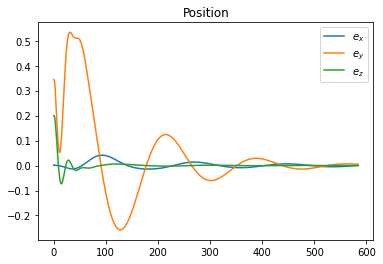

In [33]:
log = array(log)
plot(log[:,0], label='$e_x$')
plot(log[:,1], label='$e_y$')
plot(log[:,2], label='$e_z$')
title('Position')
legend()